In [1]:
# from   pathlib      import Path
# import importlib

# import numpy                as np
# import matplotlib           as mpl
# import matplotlib.pyplot    as plt
# import seaborn              as sns
# import pandas               as pd

# from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
# from scipy.optimize import curve_fit
# import statsmodels.api as sm
# from statsmodels.multivariate.manova import MANOVA
# import statsmodels.formula.api as smf
# from eidynamics     import utils, plot_tools
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12
# plt.rcParams['svg.fonttype'] = 'none'

# # make a colour map viridis
# viridis = mpl.colormaps["viridis"]
# flare   = mpl.colormaps["flare"]
# crest   = mpl.colormaps["crest"]
# magma   = mpl.colormaps["magma"]
# edge    = mpl.colormaps['edge']

# color_E = "flare"
# color_I = "crest"
# color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
# color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
# color_EI = {-70:flare(0), 0:crest(0)}
# colors_EI = {-70:flare, 0:crest}

# Fs = 2e4
# %matplotlib widget
# freq_sweep_pulses = np.arange(9)

# from eidynamics.fit_PSC     import find_sweep_expected
# # from Findsim        import tab_presyn_patterns_LR_43
# # import parse_data
# from eidynamics     import utils, plot_tools
# import all_cells
# # import plotFig2
# import stat_annotate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import plotFig2
%colors nocolor
Fs=2e4

In [15]:
# load data
figure_raw_material_location = Path(r"paper_figure_matter\\")
# paper_figure_export_location = Path(r"paper_figures\\Figure2v3_CC\\")
data_path                    = Path(r"parsed_data\\LTMRand\\")

# Load the dataset
LTM_cc_datapath =  Path(r"parsed_data\\LTMRand\\all_cells_LTMRand_CC_long.h5")
df = pd.read_hdf(LTM_cc_datapath, key='data')

# # expanded dataframe (processed dataframe with metadata and analysed params)
# expanded_data_path = Path(r"parsed_data\all_cells_FreqSweep_combined_expanded.h5")
# xc_FS_analyseddf = pd.read_hdf(expanded_data_path, key='data')

In [16]:
df.shape

(552, 80073)

In [30]:
# remove columns that are not needed
# not needed columns are 20049 to 80049
df = df.drop(df.columns[20049:80049], axis=1)
df.shape

(552, 20073)

In [29]:
df['pulseTimes']

0      [4631, 5627, 6627, 7627, 8627, 9627, 10627, 11...
1      [4627, 5627, 6627, 7627, 8627, 9627, 10627, 11...
2      [4627, 5627, 6627, 7627, 8627, 9627, 10627, 11...
3      [4627, 5627, 6627, 7627, 8627, 9627, 10627, 11...
4      [4627, 5627, 6627, 7627, 8627, 9627, 10627, 11...
                             ...                        
547     [4630, 5130, 5631, 6131, 6631, 7131, 7631, 8130]
548     [4630, 5131, 5631, 6131, 6631, 7131, 7631, 8131]
549     [4630, 5130, 5630, 6130, 6630, 7130, 7630, 8130]
550     [4628, 5131, 5631, 6131, 6630, 7130, 7631, 8130]
551     [4630, 5131, 5630, 6131, 6631, 7131, 7630, 8130]
Name: pulseTimes, Length: 552, dtype: object

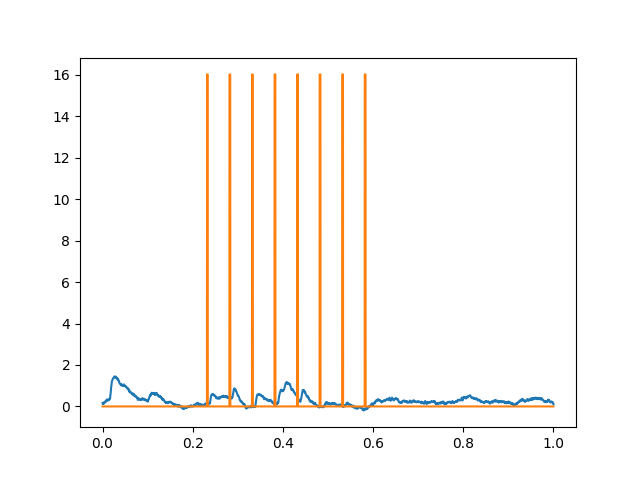

In [21]:
# plot one of the rows
%matplotlib widget
plt.figure()
plt.plot(np.linspace(0,1,20000), df.iloc[0,49:20049])
plt.plot(np.linspace(0,1,20000), 10*df.iloc[0,40049:60049])


In [33]:
import importlib
importlib.reload(plotFig2)

new_fields = ['valley_', 'valleytime_', 'peak_', 'peaktime_', 'slope_', 'delay_', 'normpeak_', 'PSC_', 'normPSC_', 'spike_']
newcolumns = [field + str(i) for field in new_fields for i in range(9)]
Fs=2e4
# Adding new columns with NaN values
df = df.assign(**{col: np.nan for col in newcolumns})
c = 0
d=0
r=0
k=0
for idx, row in df.iterrows():
    print(f"Processing row {idx} with trialID {row['trialID']}")
    # do not process if freq==10
    if row['stimFreq'] <20:
        print(f"Skipping {idx} row with trialID {row['trialID']}: Low frequency")
        d+=0
        continue
    
    try:
        if row['probePulseStart'] == row['pulseTrainStart']:
            freq = row['stimFreq']
            isi = int(0.9*Fs / freq)
            print(f"interpolating {idx} row with trialID {row['trialID']}: No probe pulse. {row['probePulseStart']} = { row['pulseTrainStart']}")
            row[2000:2000+isi] = row[4630:4630+isi]
            row[2000+isi-100:4630] = np.interp(np.arange(2000+isi-100,4630), [2000+isi-100,4630], [row[2000+isi-100], row[4630]])
            c+=1
            results = plotFig2.deconv(row[49:20049], row['stimFreq'], 0.1, row['pulseTrainStart'], None, noprobepulse=False)
        else:
            results = plotFig2.deconv(row[49:20049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=False)
    except RuntimeError:
        r+=1
        continue
    except FloatingPointError as e:
        print(f"Error at {idx} row with trialID {row['trialID']}: {e}")
        print(row['stimFreq'], row['numSq'], row['probePulseStart'], row['pulseTrainStart'])
        k+=1
        continue
    
    valleyTimes, valleys, peakTimes, peaks = results[2]
    # elementwise difference between peak and valley is PSC
    pscs = np.array(peaks) - np.array(valleys)
    normPSCs = np.array(pscs) / pscs[0]
    normpeaks = np.array(peaks) / peaks[0]
    stimTimes = np.array(results[-1]) / Fs    
    slopes = np.array([(peaks[i] - valleys[i]) / (peakTimes[i] - valleyTimes[i]) for i in range(len(peaks))])
    delays = np.array([(valleyTimes[i] - stimTimes[i]) for i in range(len(valleyTimes))])
    # spikes if peaks are greater than 20
    spikes = np.array([1 if peak > 20 else 0 for peak in peaks])

    for col in newcolumns:
        prefix, col_idx = col.split('_')
        col_idx = int(col_idx)

        if col_idx < len(valleys):  # Ensure index is within bounds
            if prefix == 'valley':
                df.loc[row.name, col] = valleys[col_idx]
            elif prefix == 'valleytime':
                df.loc[row.name, col] = valleyTimes[col_idx]
            elif prefix == 'peak':
                df.loc[row.name, col] = peaks[col_idx]
            elif prefix == 'peaktime':
                df.loc[row.name, col] = peakTimes[col_idx]
            elif prefix == 'slope':
                df.loc[row.name, col] = slopes[col_idx]
            elif prefix == 'delay':
                df.loc[row.name, col] = delays[col_idx]
            elif prefix == 'normpeak':
                df.loc[row.name, col] = normpeaks[col_idx]
            elif prefix == 'PSC':
                df.loc[row.name, col] = pscs[col_idx]
            elif prefix == 'normPSC':
                df.loc[row.name, col] = normPSCs[col_idx]
            elif prefix == 'spike':
                df.loc[row.name, col] = spikes[col_idx]


    # counter for every 100 rows
    if idx % 100 == 0:
        print(f"Processed {idx} rows")

# Assuming df is your final DataFrame
metadata_cols1 = df.iloc[:, :49]
metadata_cols2 = df.iloc[:, 20049:]

# Concatenating the two slices into a new DataFrame
new_df = pd.concat([metadata_cols1, metadata_cols2], axis=1)

# Display the shape of the new DataFrame to verify
print(new_df.shape)
print(f"Kernel errors: {k}, Runtime errors: {r}, No probe pulse: {c}, Low frequency: {d}")

Processing row 0 with trialID 5211_12_1
interpolating 0 row with trialID 5211_12_1: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 231 0.5887173414230347 0.1 0.23100000619888306 1000 (1696,) [0.47591507 0.15572974]
Processed 0 rows
Processing row 1 with trialID 5211_12_2
interpolating 1 row with trialID 5211_12_2: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 175 0.7218549251556396 0.1 0.23100000619888306 1000 (1696,) [4.97965322e-02 4.94355043e+05]
Processing row 2 with trialID 5211_12_3
interpolating 2 row with trialID 5211_12_3: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 213 0.7727070450782776 0.1 0.23100000619888306 1000 (1696,) [0.22643621 0.27408192]
Processing row 3 with trialID 5211_12_4
interpolating 3 row with trialID 5211_12_4: No probe pulse. 0.231000006198883

c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 682 -1.9327261447906494 0.1 0.23100000619888306 1000 (1696,) [-2.05056705  0.09110796]
Processing row 18 with trialID 5211_12_19
interpolating 18 row with trialID 5211_12_19: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 729 -1.7657124996185303 0.1 0.23100000619888306 1000 (1696,) [-1.92009374  0.06967291]
Processing row 19 with trialID 5211_12_20
interpolating 19 row with trialID 5211_12_20: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 182 3.218668222427368 0.1 0.23100000619888306 1000 (1696,) [1.26423699 0.00493039]
Processing row 20 with trialID 5211_12_21
interpolating 20 row with trialID 5211_12_21: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 641 -2.5370850563049316 0.1 0.23100000619888306 1000 (1696,) [-2.

c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\plotFig2.py:48: RuntimeWarning: overflow encountered in exp
  ret, cov = sci.curve_fit(lambda t,a,tau: a*np.exp(-t/tau), x, y, p0=(pk-baseline,0.02) )


Processing row 78 with trialID 3781_9_7
interpolating 78 row with trialID 3781_9_7: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 509 0.4265301823616028 0.1 0.23100000619888306 1000 (1696,) [0.47247959 0.01629862]
Processing row 79 with trialID 3781_9_8
interpolating 79 row with trialID 3781_9_8: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 302 0.4609019160270691 0.1 0.23100000619888306 1000 (1696,) [2.50355092e-01 3.68076469e+06]
Processing row 80 with trialID 3781_9_9
interpolating 80 row with trialID 3781_9_9: No probe pulse. 0.23100000619888306 = 0.23100000619888306
[2000, 4620, 5620, 6620, 7620, 8620, 9620, 10620, 11620] 20 648 0.5247947573661804 0.1 0.23100000619888306 1000 (1696,) [3.76596771e-01 4.69184846e+05]
Processing row 81 with trialID 3781_9_10
interpolating 81 row with trialID 3781_9_10: No probe pulse. 0.23100000619888306 = 0.

In [34]:
print(new_df.shape)
# save df
new_df.to_hdf(data_path / "all_cells_LTM_CC_kernelfit_response_measurements.h5", key='data', mode='w')
# save as excel
new_df.to_excel(data_path / "all_cells_LTM_CC_kernelfit_response_measurements.xlsx")

# drop those rows from df that have NaN values in column 'valley_0'
new_df = new_df.dropna(subset=['valley_0'])
print(new_df.shape)

(552, 163)


C:\Users\adity\AppData\Local\Temp\ipykernel_60504\1923338301.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block5_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'condition', 'numPatterns', 'patternList', 'frameChangeTimes',
       'pulseTimes', 'peaks_cell', 'peaks_cell_norm', 'auc_cell', 'slope_cell',
       'delay_cell', 'peaks_field', 'peaks_field_norm', 'cell_fpr',
       'field_fpr', 'cell_ppr', 'cell_stpr', 'field_ppr', 'field_stpr',
       'trialID', 'cellunit', 'fieldunit'],
      dtype='object')]

  new_df.to_hdf(data_path / "all_cells_LTM_CC_kernelfit_response_measurements.h5", key='data', mode='w')


(540, 163)


In [35]:
# save df
new_df.to_hdf(data_path / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.h5", key='data', mode='w')
# save as excel
new_df.to_excel(data_path / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.xlsx")

C:\Users\adity\AppData\Local\Temp\ipykernel_60504\1953425538.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block5_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'condition', 'numPatterns', 'patternList', 'frameChangeTimes',
       'pulseTimes', 'peaks_cell', 'peaks_cell_norm', 'auc_cell', 'slope_cell',
       'delay_cell', 'peaks_field', 'peaks_field_norm', 'cell_fpr',
       'field_fpr', 'cell_ppr', 'cell_stpr', 'field_ppr', 'field_stpr',
       'trialID', 'cellunit', 'fieldunit'],
      dtype='object')]

  new_df.to_hdf(data_path / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.h5", key='data', mode='w')
